# 1. Install PIP's

In [1]:
%pip install unidecode
%pip install spacy
%pip install seaborn
%pip install nltk
%pip install stats
%pip install xgboost
%pip install sweetviz
%pip install string
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string


Note: you may need to restart the kernel to use updated packages.


# 2. Import Packages

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import spacy
nlp = spacy.load('pt_core_news_lg')
import string
import regex as re
from unidecode import unidecode
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# 3. Load Data

In [3]:
customers_df = pd.read_csv("olist_customers_dataset.csv")
geolocation_df = pd.read_csv("olist_geolocation_dataset.csv")
order_items_df = pd.read_csv("olist_order_items_dataset.csv")
order_payments_df = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv")
orders_df = pd.read_csv("olist_orders_dataset.csv")
products_df = pd.read_csv("olist_products_dataset.csv")
sellers_df = pd.read_csv("olist_sellers_dataset.csv")
product_category_name_translation_df = pd.read_csv("product_category_name_translation.csv")

# 4. Data Wreangling

### 4.1. Merge Data

In [4]:
df = orders_df.merge(order_reviews_df, on='order_id')\
                   .merge(order_items_df, on='order_id')\
                   .merge(products_df, on='product_id')\
                   .merge(sellers_df, on='seller_id')\
                   .merge(geolocation_df, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')

### 4.2. Selected Columns Important

In [5]:
selected_columns = ['review_id', 'review_score', 'review_comment_title', 
                    'review_comment_message', 'review_creation_date', 
                    'review_answer_timestamp', 'product_id', 
                    'geolocation_lat', 'geolocation_lng']

full_df = df.loc[:, selected_columns]

### 4.3. Conversion Columns Data in datetime

In [6]:
datetime_columns = ['review_creation_date', 'review_answer_timestamp']
full_df[datetime_columns] = full_df[datetime_columns].apply(pd.to_datetime)

### 4.4. Drop Duplicates

In [7]:
full_df = full_df.drop_duplicates(subset=['review_id'])

### 4.5. Merge Title with Message

In [8]:
full_df['review_comment_title'] = full_df['review_comment_title'].fillna('').astype(str)
full_df['text_sentiment'] = full_df['review_comment_title'].str.cat(full_df['review_comment_message'], sep=' ')

### 4.6. Drop NA

In [9]:
full_df = full_df.dropna(subset=['text_sentiment'])
full_df = full_df.dropna(subset=['review_score'])

# 5. Data Processing

### 5.1. Conversion Column Message in Lower Case

In [11]:
def to_lower(text):
    return text.lower()

In [12]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(to_lower)

### 5.2. Removing Punctuation, Exemple (".", "!")

In [13]:
def remove_punctuation(text):
    punct = string.punctuation
    punct = punct.replace("'", "")
    translator = str.maketrans('', '', punct)
    return text.translate(translator)

In [14]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_punctuation)

### 5.3. Removing Emoji

In [15]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # simbol and pictogramas
                               u"\U0001F680-\U0001F6FF"  # transport and ]simbol of map
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [16]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_emojis)

### 5.4. Removing Sites and Blogs

In [17]:
def remove_urls(text):
    http = r"http\S+|www\.\S+"
    pattern = re.compile(r"({})".format(http))
    return pattern.sub(r'', text)

In [18]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_urls)

### 5.5. Removing Accentuation

In [19]:
def remove_accent(text):
    return unidecode(text)

In [20]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_accent)

### 5.6. Remove Numbers

In [21]:
def remove_numbers(texto):
    return re.sub(r'\d+', '', texto)

In [22]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_numbers)

### 5.7. Remove Space Blank Excessive and Remove Broke Line

In [23]:
def remove_broke_line(texto):
    return texto.replace('\n', ' ')

In [24]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(remove_broke_line)

### 5.8. Remove Blank Space Text

In [25]:
def strip_text(text):
    return text.strip()

In [26]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(strip_text)

### 5.9. Filter only Adjetivos, Verbos, Substantivo, Adverbios and "nao" "nada"

In [27]:
def filtrar_tokens(text):
    doc = nlp(text)
    tokens_filtrados = []
    for token in doc:
        if token.text.lower() == 'nao':
            tokens_filtrados.append(token.text)
        elif token.text.lower() == 'nada':
            tokens_filtrados.append(token.text)
        elif token.pos_ in ['ADJ', 'VERB', 'NOUN', 'ADV']:
            tokens_filtrados.append(token.text)
    return ' '.join(tokens_filtrados)

In [28]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(filtrar_tokens)

### 5.10. Lematization

In [29]:
def lemmatize_text(text):
    return " ".join([token.lemma_ for token in nlp(text)])

In [30]:
full_df['text_sentiment'] = full_df['text_sentiment'].apply(lemmatize_text)

In [31]:
full_df.head(20)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng,text_sentiment
0,a54f0611adc9ed256b57ede6b6eb5114,4,,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,2017-10-12 03:43:48,87285b34884572647811a353c7ac498a,-23.680114,-46.452454,nao testar produto ainda vir correto bom condi...
207,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08,2018-08-08 18:37:50,595fac2a385ac33a80bd5114aec74eb8,-19.810119,-43.984727,muito bom loja muito bom produto
448,359d03e676b3c069f62cadba8dd3f6e8,5,,O produto foi exatamente o que eu esperava e e...,2017-12-03,2017-12-05 19:21:58,d0b61bfb1de832b15ba9d266ca96e5b0,-19.840168,-43.923299,produto exatamente esperar descrito site chega...
620,e07549ef5311abcc92ba1784b093fb56,2,,fiquei triste por n ter me atendido.,2017-05-13,2017-05-13 20:25:42,a1804276d9941ac0733cfd409f5206eb,-23.536892,-46.713111,fiquei triste n atendir
1468,15898b543726a832d4137fbef5d1d00e,1,,Aguardando retorno da loja,2017-05-30,2017-05-30 23:13:47,08574b074924071f4e201e151b152b4e,-20.297537,-40.400869,aguardar retorno lojar
2180,8f39f09c22b1ceb6e3eb178d8e50bb8a,4,,Gostei do produto,2018-03-13,2018-03-14 10:36:16,72d3bf1d3a790f8874096fcf860e3eff,-26.916270,-48.652460,gostar produto
2415,5a8608437f4b52bec5cd143f37258b5e,5,Nota dez,Obrigado pela atenção. Lojas lannister perfeit...,2018-07-03,2018-07-03 15:10:07,009c09f439988bc06a93d6b8186dce73,-15.836123,-48.040185,nota obrigado atencao loja perfeito
2881,38cae21b1b57a95959440380d5b2ef7a,2,,os correios estäo em greve... näo recebi nenhu...,2017-10-01,2017-10-01 17:55:21,5ac9d9e379c606e36a8094a6046f75dc,-23.677741,-46.668647,Correios greve nao receber aviso atraso qqer f...
3240,9a55cbc65c8fad47581da5ebbb2b373e,5,Ótimo,Sempre vou comprar aqui pois é a melhor parabéns,2018-08-14,2018-08-14 21:52:46,e99d69efe684efaa643f99805f7c81bc,-21.728866,-48.688815,otimo sempre comprar aqui pois bom parabens
3308,6a1a8e54de03ab98e6e8ff56e56e507f,2,,Demora muito entregar. Já passou o prazo e ain...,2018-03-16,2018-03-20 23:10:58,7b717060aa783eb7f23a747a3a733dd7,-23.624784,-46.539542,demorar muito entregar passar prazo ainda nao ...


# 6. Previus Analyze

In [33]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes,columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column','dtypes']]
    metadata['# Missing'] = df.isnull().sum().values    
    metadata['# Unique'] = df.nunique().values
    metadata['Example'] = df.loc[0].values

    for name in metadata['Column'].value_counts().index:
        metadata.loc[metadata['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return metadata
    
df_metadata(full_df)

,Column,dtypes,# Missing,# Unique,Example,Entropy
0,review_id,object,0,40095,a54f0611adc9ed256b57ede6b6eb5114,15.29
1,review_score,int64,0,5,4,1.90
2,review_comment_title,object,0,4089,,3.22
3,review_comment_message,object,0,35625,"Não testei o produto ainda, mas ele veio corre...",14.78
4,review_creation_date,datetime64[ns],0,618,2017-10-11 00:00:00,8.78
5,review_answer_timestamp,datetime64[ns],0,40069,2017-10-12 03:43:48,15.29
6,product_id,object,0,17970,87285b34884572647811a353c7ac498a,13.17
7,geolocation_lat,float64,0,1891,-23.680114,8.82
8,geolocation_lng,float64,0,1891,-46.452454,8.82
9,text_sentiment,object,0,32713,nao testar produto ainda vir correto bom condi...,14.27


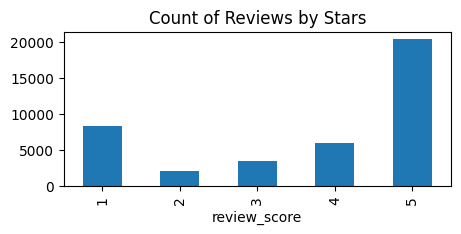

In [32]:
ax = full_df['review_score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5,2))

In [34]:
example = full_df['text_sentiment'].iloc[4]
print(example)

aguardar retorno lojar


# 7. Training Model

### 7.1. Separeting Dataframe Training and Dataframe Test After Training

In [36]:
# Amostra os dados para df_train
df_train = full_df.sample(frac=0.95, random_state=45, ignore_index=True)

# Seleciona as linhas que não estão presentes em df_train para df_remaining
df_remaining = full_df.loc[~full_df.index.isin(df_train.index)].reset_index(drop=True)

### 7.2. Classifier Review Score Negative with 0 (Review 1 or 2) and Positive with 1 (Review 3,4 or 5)

In [37]:
df_train['sentiment'] = df_train['review_score'].apply(lambda x: 0 if x in [1,2,3] else 1)

In [38]:
df_train.head(5)

,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_id,geolocation_lat,geolocation_lng,text_sentiment,sentiment
0,ca3199bb0d98c494fd25dbf79e50e661,5,,Uahlll! Recebi minha compra 30 dias antes do p...,2017-01-17,2017-01-17 12:50:12,7ead55b1f52de17d6dac82001470b2a2,-25.511232,-49.303111,recebi compra dia antes prazo definir adorar c...,1
1,65e1734b87fcf83d834e141e1deee410,5,,Adorei o relógio e chegou rápido!,2017-12-30,2017-12-30 21:38:37,8317b177579dd27ff068b83205e2169b,-21.362358,-48.232976,adorei relogio chegar rapido,1
2,5c1ba09de5c746017d406bd2cfefeca3,3,nao entrega do produto,recebe apenas 01 peça do produto! estou precis...,2018-04-26,2018-04-26 13:36:47,25c38557cf793876c5abdd5931f922db,-22.760478,-47.412811,nao entregar produto receber apenas pecar prod...,0
3,a3d3d770c3574d9847e5ed349a1e142e,5,Ótimo,Muito bom,2018-05-08,2018-05-11 00:42:40,7bdc3ff2d6af39d08fb40546ba7b9766,-26.859080,-48.639536,otimo muito bom,1
4,2dc6a14196ad670861710b19f3d5df6f,1,,Já passou 3 dias e o produto não foi entregue.,2017-06-30,2017-07-01 15:32:17,f811e4e8228504bcdd34f2fe9f502c92,-23.606632,-46.668066,passar dia produto nao entregar,0


### 7.3. Selecting Columns Necessary for Training

In [39]:
selected_columns = ['text_sentiment', 'sentiment']
df_classification = df_train.loc[:, selected_columns]

In [40]:
df_classification.head(5)

,text_sentiment,sentiment
0,recebi compra dia antes prazo definir adorar c...,1
1,adorei relogio chegar rapido,1
2,nao entregar produto receber apenas pecar prod...,0
3,otimo muito bom,1
4,passar dia produto nao entregar,0


### 7.4. Divising Dataframe Between Train and Test

In [42]:
comment_train, comment_test, sentiment_train, sentiment_test = train_test_split(
                                                                                df_classification['text_sentiment'],
                                                                                df_classification['sentiment'], 
                                                                                test_size=0.2,
                                                                                random_state=24)

### 7.5. Inicializing Training IA

In [43]:
vectorizer = TfidfVectorizer()

In [44]:
ctmTr = vectorizer.fit_transform(comment_train)
comment_test_dtm = vectorizer.transform(comment_test)

In [45]:
smote = SMOTE(random_state=42)
ctmTr_resampled, sentiment_train_resampled = smote.fit_resample(ctmTr, sentiment_train)

In [46]:
normalization = preprocessing.StandardScaler(with_mean=False)

In [47]:
normalization.fit(ctmTr_resampled)
X = normalization.transform(ctmTr_resampled)

In [50]:
analyze_sentiment = MLPClassifier(hidden_layer_sizes=(32,16,16,1),
                                   activation='relu',
                                   solver='adam',
                                   learning_rate='constant',
                                   max_iter=100,
                                   early_stopping=True,
                                   n_iter_no_change=10,
                                   verbose=True)

history = analyze_sentiment.fit(X, sentiment_train_resampled)

Iteration 1, loss = 0.57432116
Validation score: 0.863807
Iteration 2, loss = 0.44478284
Validation score: 0.871583
Iteration 3, loss = 0.36647313
Validation score: 0.871833
Iteration 4, loss = 0.32302025
Validation score: 0.879609
Iteration 5, loss = 0.29099895
Validation score: 0.884123
Iteration 6, loss = 0.26689542
Validation score: 0.881866
Iteration 7, loss = 0.24715357
Validation score: 0.881615
Iteration 8, loss = 0.23241468
Validation score: 0.884374
Iteration 9, loss = 0.22159502
Validation score: 0.889641
Iteration 10, loss = 0.21017836
Validation score: 0.886882
Iteration 11, loss = 0.20186887
Validation score: 0.886130
Iteration 12, loss = 0.19515146
Validation score: 0.885628
Iteration 13, loss = 0.18789359
Validation score: 0.886632
Iteration 14, loss = 0.18244899
Validation score: 0.884876
Iteration 15, loss = 0.17967297
Validation score: 0.884625
Iteration 16, loss = 0.17504947
Validation score: 0.884625
Iteration 17, loss = 0.17184838
Validation score: 0.884625
Iterat

# 8. Analyze Performance IA

### 8.1. Score

In [51]:
X_test = normalization.transform(comment_test_dtm)
analyze_sentiment.score(X_test,sentiment_test)

0.8625623523234445

### 8.2. Graph Loss and Score During Training

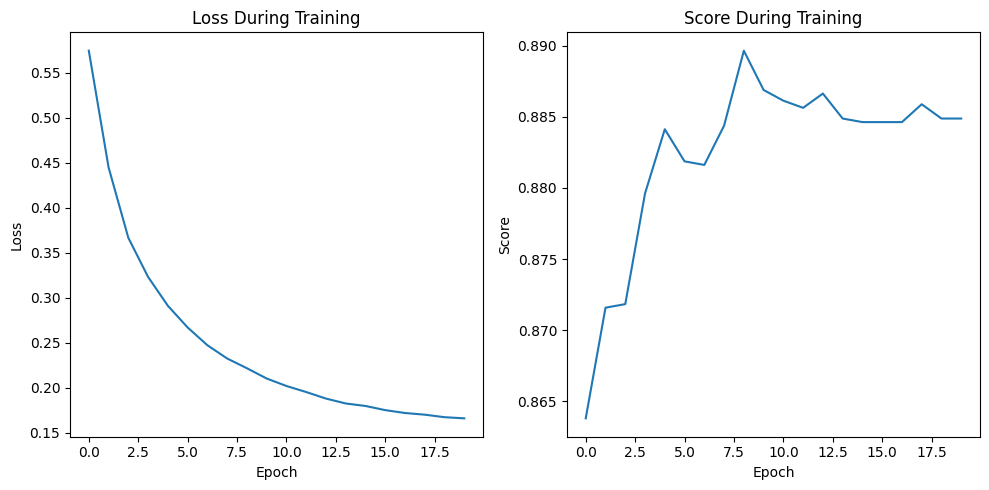

In [52]:
plt.figure(figsize=(10, 5))
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.loss_curve_)
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.validation_scores_)
plt.title('Score During Training')
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

### 8.3. Confusion Matrix

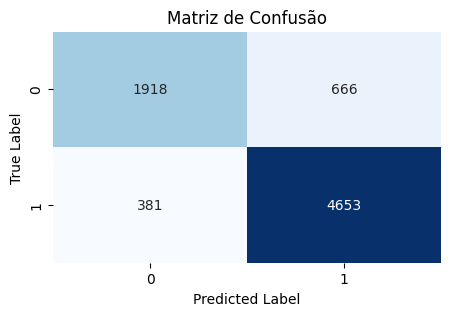

In [53]:
predictions = analyze_sentiment.predict(X_test)
conf_matrix = confusion_matrix(sentiment_test, predictions)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 8.4. Curve ROC

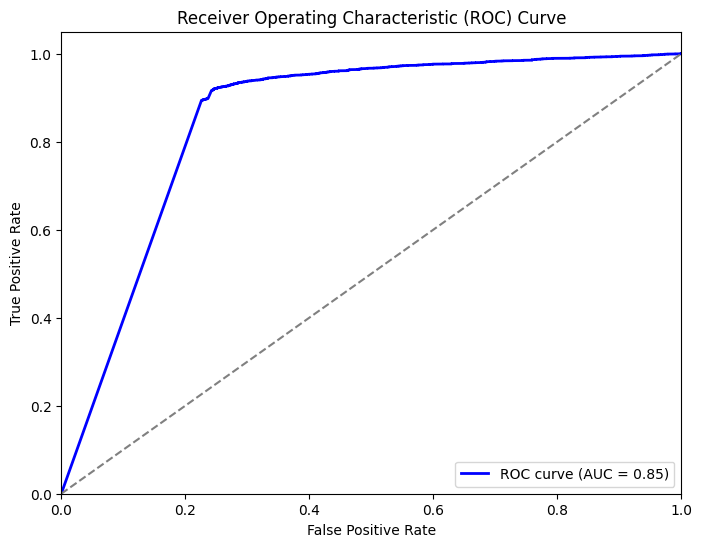

In [54]:
probas_pred = analyze_sentiment.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(sentiment_test, probas_pred)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 9. Test and Deploy IA

In [55]:
# Ajustar configurações para mostrar o texto completo
pd.set_option('display.max_colwidth', None)

texto_teste_vetorizado = vectorizer.transform(df_remaining['review_comment_message'])
texto_teste_normalizado = normalization.transform(texto_teste_vetorizado)
sentimento_predito = analyze_sentiment.predict(texto_teste_normalizado)

df_remaining['sentimento_predito'] = sentimento_predito

df_remaining['sentimento_predito'] = df_remaining['sentimento_predito'].replace({0: 'negativo', 1: 'positivo'})

print(df_remaining[['review_comment_message', 'review_score', 'sentimento_predito']])

df_remaining[['review_id','review_comment_message', 'review_score', 'sentimento_predito']].to_csv('dados_processados.csv', index=False)


                                                                                           review_comment_message  \
0                                                                                         entrega antes do prazo    
1      Satisfeito 100%; recebi bem antes do prazo estimado; só falta testá-lo (não acompanha o cartucho de tinta)   
2                                                               Gostei do que comprei e ficou muito legal na moto   
3                                                                                                 Bom atendimento   
4                                              indico produto de alta qualidade, recebi antes do prazo combinado.   
...                                                                                                           ...   
39995                               Otimo comprar por este site as mercadorias chegam antes do prazo determinado.   
39996                     Ele não é um mini cajon, é um shaker, 

In [77]:
from collections import Counter

# Filtrar mensagens positivas e negativas
mensagens_positivas = df_remaining[df_remaining['sentimento_predito'] == 'positivo']['review_comment_message']
mensagens_negativas = df_remaining[df_remaining['sentimento_predito'] == 'negativo']['review_comment_message']

# Função para contar palavras mais comuns
def contar_palavras(mensagens):
    todas_mensagens = ' '.join(mensagens)
    palavras = todas_mensagens.split()
    contagem_palavras = Counter(palavras)
    return contagem_palavras.most_common(10)

# Contar palavras mais comuns para mensagens positivas
print("Palavras mais comuns em mensagens positivas:")
print(contar_palavras(mensagens_positivas))

# Contar palavras mais comuns para mensagens negativas
print("\nPalavras mais comuns em mensagens negativas:")
print(contar_palavras(mensagens_negativas))

KeyError: 'sentimento_predito'

## division

In [ ]:
# Definir os hiperparâmetros a serem testados
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Criar o modelo MLPClassifier
mlp = MLPClassifier(max_iter=100)

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=2)

# Treinar o modelo usando a pesquisa em grade
grid_search.fit(X, sentiment_train)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Avaliar o desempenho do modelo
print("Acurácia da melhor configuração no conjunto de validação:")
print(grid_search.best_score_)